# **Intro**

This script will compare DIVA, Cybersort, and BayesPrism results.
In this experimental set-up, all models are trained on pbmc_rep2_10xV2.
It is then tested on an augmented/simulated bulk versions of the following single cell sample IDs

1.   pbmc_rep2_10xV2
2.   pbmc_rep1_10xV2a (different sample)
3.   pbmc_rep1_sm2 (different sample and technology)

The augmentation is done by sampling the cell proportions and overall cell numbers.
In addition there are two sources of noise: cell-type specific noise and sample specific noise.
This noise is generated by sampling a 1-centered log-normal distribution that represents a fold-change.
The sample-specific fold-change vector is sampled once per bulk sample.
The cell-type specific fold-change vectors are sampled independently, one per cell-type. 


# **Github / VM setup**

To integrate Colab with github, we need to do some setup first.
If you want this to integrate with your own github repo, you will need to create a `secrets` folder that contain your public and private key, and register this to access you github repo. Check `setup.sh` for more details.

In [29]:
import os, sys
RUN_COLAB = False

if RUN_COLAB:
    NB_ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood'
    sys.path.append('/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood')


In [30]:
# prelude: set up git, etc.
if RUN_COLAB:
    %cd {NB_ROOT_PATH}
    !( source setup.sh )


In [31]:
if RUN_COLAB:
    print("hi")
    # do your git operations here
    %%bash
    #git status


# **Imports**

In [42]:
# general imports
import warnings
import numpy as np
import os
import pandas as pd
import scipy as sp
from scipy.stats import spearmanr, pearsonr


# Images, plots, display, and visualization
import plotnine as gg
import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import gzip
from pathlib import Path

pd.set_option("display.max_columns", None)



# Load Results

In [33]:
aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_pbmc_data/"
diva_res_data_path = f"{os.getcwd()}/../results/single_cell_data/diva_pbmc/"
cs_res_data_path = f"{os.getcwd()}/../results/single_cell_data/cibersort_pbmc/"
bp_res_data_path = f"{os.getcwd()}/../results/single_cell_data/bp_pbmc/"

def read_files(data_path, file_idx, file_name):
  pbmc_rep1_pseudobulk_file = os.path.join(data_path, f"{file_name}_pseudo_{file_idx}.pkl")
  pbmc_rep1_prop_file = os.path.join(data_path, f"{file_name}_prop_{file_idx}.pkl")
  pbmc_rep1_gene_file = os.path.join(data_path, f"{file_name}_genes.pkl")

  pseudobulk_path = Path(pbmc_rep1_pseudobulk_file)
  prop_path = Path(pbmc_rep1_prop_file)
  gene_path = Path(pbmc_rep1_gene_file)

  prop_df = pickle.load( open( prop_path, "rb" ) )
  pseudobulks_df = pickle.load( open( pseudobulk_path, "rb" ) )
  gene_df = pickle.load( open( gene_path, "rb" ) )

  return (pseudobulks_df, prop_df, gene_df)

def read_results(data_path, file_name, method_str, ext):
  res_file = os.path.join(data_path, f"train-pbmc_rep2_10xV2-test-{file_name}-{method_str}.{ext}")
  res_path = Path(res_file)

  if ext == "pkl":
    res_df = pickle.load( open( res_path, "rb" ) )
  elif ext == "csv":
    res_df = pd.read_csv(res_file)
  else:
    res_df = pd.read_csv(res_file, sep="\t")

  return res_df


# load the TRUE labels
X_unseen, Y_unseen, unseen_gene_df = read_files(aug_data_path, 0, "pbmc_rep2_10xV2") #0
X_newsamp, Y_newsamp, newsamp_gene_df = read_files(aug_data_path, 0, "pbmc_rep1_10xV2a")
X_newtech, Y_newtech, newtech_gene_df = read_files(aug_data_path, 0, "pbmc_rep1_sm2")

# make sure cell types are in the same order
Y_newsamp = Y_newsamp[Y_unseen.columns]
Y_newsamp = Y_newsamp.to_numpy()

# we also need to ensure that the cell-types that are unobserved are still there
Y_newtech['Natural killer cell'] = 0
Y_newtech['Dendritic cell'] = 0
Y_newtech['Plasmacytoid dendritic cell'] = 0
Y_newtech = Y_newtech[Y_unseen.columns]
Y_newtech = Y_newtech.to_numpy()


# load the DIVA results
diva_unseen = read_results(diva_res_data_path, "pbmc_rep2_10xV2", "DIVA", "pkl")
diva_newsamp = read_results(diva_res_data_path, "pbmc_rep1_10xV2a", "DIVA", "pkl")
diva_newtech = read_results(diva_res_data_path, "pbmc_rep1_sm2", "DIVA", "pkl")

diva_unseen = diva_unseen[Y_unseen.columns]
diva_unseen = diva_unseen.to_numpy()

diva_newsamp = diva_newsamp[Y_unseen.columns]
diva_newsamp = diva_newsamp.to_numpy()

diva_newtech = diva_newtech[Y_unseen.columns]
diva_newtech = diva_newtech.to_numpy()


# load the cibersort results
cs_str = "CIBERSORTx_Job4_Results"
cs_unseen = read_results(cs_res_data_path, "pbmc_rep2_10xV2", cs_str, "csv")
cs_str = "CIBERSORTx_Job5_Results"
cs_newsamp = read_results(cs_res_data_path, "pbmc_rep1_10xV2a", cs_str, "csv")
cs_str = "CIBERSORTx_Job6_Results"
cs_newtech = read_results(cs_res_data_path, "pbmc_rep1_sm2", cs_str, "csv")

cs_unseen = cs_unseen[Y_unseen.columns]
cs_unseen = cs_unseen.to_numpy()

cs_newsamp = cs_newsamp[Y_unseen.columns]
cs_newsamp = cs_newsamp.to_numpy()

cs_newtech = cs_newtech[Y_unseen.columns]
cs_newtech = cs_newtech.to_numpy()


# load the bayesprism results
bp_str = "bp_1000_prop"
bp_unseen = read_results(bp_res_data_path, "pbmc_rep2_10xV2", bp_str, "tsv")
bp_newsamp = read_results(bp_res_data_path, "pbmc_rep1_10xV2a", bp_str, "tsv")
bp_newtech = read_results(bp_res_data_path, "pbmc_rep1_sm2", bp_str, "tsv")

bp_unseen = bp_unseen[Y_unseen.columns]
bp_unseen = bp_unseen.to_numpy()

bp_newsamp = bp_newsamp[Y_unseen.columns]
bp_newsamp = bp_newsamp.to_numpy()

bp_newtech = bp_newtech[Y_unseen.columns]
bp_newtech = bp_newtech.to_numpy()


Y_unseen = Y_unseen.to_numpy()


# Compare Methods

In [34]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

def mean_sqr_error(y_pred, y_true):
  return np.mean((y_pred - y_true)**2)

def get_errors(y_true, y_est):
  mse_err = [mean_sqr_error(y_true[idx], y_est[idx]) 
                  for idx in range(0, y_est.shape[0])]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"]*y_est.shape[0] + ["SPR"]*y_est.shape[0] + ["PEAR"]*y_est.shape[0]

  return plot_df



In [35]:
diva_unseen_err = get_errors(Y_unseen, diva_unseen)
diva_unseen_err["experiment"] = ["holdout"]*Y_unseen.shape[0]*3
diva_unseen_err["method"] = ["diva"]*Y_unseen.shape[0]*3

diva_newsamp_err = get_errors(Y_newsamp, diva_newsamp)
diva_newsamp_err["experiment"] = ["newsamp"]*Y_unseen.shape[0]*3
diva_newsamp_err["method"] = ["diva"]*Y_unseen.shape[0]*3

diva_newtech_err = get_errors(Y_newtech, diva_newtech)
diva_newtech_err["experiment"] = ["newtech"]*Y_unseen.shape[0]*3
diva_newtech_err["method"] = ["diva"]*Y_unseen.shape[0]*3


cs_unseen_err = get_errors(Y_unseen, cs_unseen)
cs_unseen_err["experiment"] = ["holdout"]*Y_unseen.shape[0]*3
cs_unseen_err["method"] = ["cs"]*Y_unseen.shape[0]*3

cs_newsamp_err = get_errors(Y_newsamp, cs_newsamp)
cs_newsamp_err["experiment"] = ["newsamp"]*Y_unseen.shape[0]*3
cs_newsamp_err["method"] = ["cs"]*Y_unseen.shape[0]*3

cs_newtech_err = get_errors(Y_newtech, cs_newtech)
cs_newtech_err["experiment"] = ["newtech"]*Y_unseen.shape[0]*3
cs_newtech_err["method"] = ["cs"]*Y_unseen.shape[0]*3



bp_unseen_err = get_errors(Y_unseen, bp_unseen)
bp_unseen_err["experiment"] = ["holdout"]*bp_unseen.shape[0]*3
bp_unseen_err["method"] = ["bp"]*bp_unseen.shape[0]*3


bp_newsamp_err = get_errors(Y_newsamp, bp_newsamp)
bp_newsamp_err["experiment"] = ["newsamp"]*bp_newsamp.shape[0]*3
bp_newsamp_err["method"] = ["bp"]*bp_newsamp.shape[0]*3


bp_newtech_err = get_errors(Y_newtech, bp_newtech)
bp_newtech_err["experiment"] = ["newtech"]*bp_newtech.shape[0]*3
bp_newtech_err["method"] = ["bp"]*bp_newtech.shape[0]*3


MSqE mean: 0.01911769413970331, median: 0.01714898489404785, max: 0.08467716922019401
Spearman mean: -0.0031403703870790693, median: 0.0, max: 0.9500000000000001
Pearson mean: -0.01284428817013727, median: -0.08751630719417922, max: 0.9368042715681514
MSqE mean: 0.00381059870346623, median: 0.003190232245149074, max: 0.01961010711228048
Spearman mean: 0.5947655873350487, median: 0.6333333333333333, max: 0.9833333333333333
Pearson mean: 0.7513859077666587, median: 0.823788405053697, max: 0.9969699016704004
MSqE mean: 0.032537345616973454, median: 0.02802199613751731, max: 0.1299114476665254
Spearman mean: 0.16163568513137017, median: 0.16562730837468242, max: 0.910844487911861
Pearson mean: 0.14300043946640273, median: 0.08834363068121082, max: 0.9741538755117715
MSqE mean: 0.008858584535022442, median: 0.007693677813109066, max: 0.05137687897431338
Spearman mean: 0.6062375908382581, median: 0.6401729676981281, max: 0.9666666666666667
Pearson mean: 0.6319409945750074, median: 0.68251955

[ 1. 10. 25.  2. 14.  5.  2. 11. 28.]
[ 1.  7.  5.  2. 68.  4.  1.  5.  8.]
[0.01047201 0.00555672 0.0579975  0.00556221 0.14483979 0.00409252
 0.02102522 0.00187865 0.02246324 0.0075958 ]
[0.0975 0.06 0.3805 0.058 0.677 0.045 0.1495 0.0185 0.197 0.0685]
pearson: 0.9863563374484208


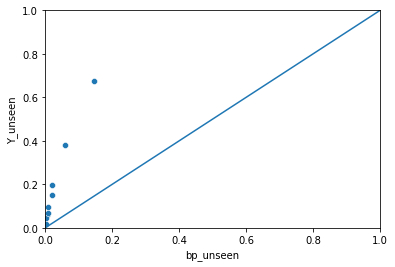

In [38]:
idx = 4
print(np.round(bp_unseen[idx,]*100))
print(np.round(Y_unseen[idx,:].astype(np.double)*100))

np.mean((bp_unseen[idx,] - Y_unseen[idx,:])**2)

print(bp_unseen[0:10,idx])
print(Y_unseen[0:10,idx])
print(f"pearson: {pearsonr(bp_unseen[0:10,idx], Y_unseen[0:10,idx])[0]}")

plot_matr = np.vstack((np.round(bp_unseen[0:10,idx],3), Y_unseen[0:10,idx]))
plot_df = pd.DataFrame(plot_matr.transpose())
plot_df.columns = ["bp_unseen", "Y_unseen"]

gg = sns.scatterplot(
    x="bp_unseen", y="Y_unseen",
    data=plot_df
)
gg.set(ylim=(0, 1))
gg.set(xlim=(0, 1))
gg.plot([0, 1], [0, 1], transform=gg.transAxes)


In [ ]:
bp_unseen.shape

(1000, 9)

[22. 18. 18. 21.  2.  4.  3.  4.  7.]
[ 1.  7.  5.  2. 68.  4.  1.  5.  8.]
[0.06367922 0.05604685 0.02960305 0.04773217 0.02411075 0.0585501
 0.05057136 0.08415671 0.05527681 0.09281378]
[0.0975 0.06 0.3805 0.058 0.677 0.045 0.1495 0.0185 0.197 0.0685]
pearson: 0.02708725834090998


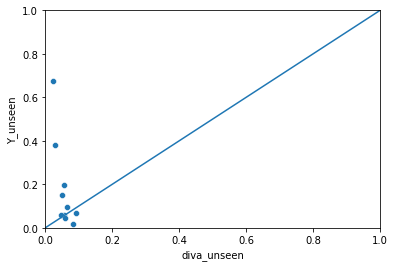

In [39]:
print(np.round(diva_unseen[idx,]*100))
print(np.round(Y_unseen[idx,:].astype(np.double)*100))


np.mean((diva_unseen[idx,] - Y_unseen[idx,:])**2)

print(diva_unseen[0:10,idx])
print(Y_unseen[0:10,idx])
print(f"pearson: {pearsonr(diva_unseen[:,idx], Y_unseen[:,idx])[0]}")

plot_matr = np.vstack((np.round(diva_unseen[0:10,idx],3), Y_unseen[0:10,idx]))
plot_df = pd.DataFrame(plot_matr.transpose())
plot_df.columns = ["diva_unseen", "Y_unseen"]

gg = sns.scatterplot(
    x="diva_unseen", y="Y_unseen",
    data=plot_df
)
gg.set(ylim=(0, 1))
gg.set(xlim=(0, 1))
gg.plot([0, 1], [0, 1], transform=gg.transAxes)


In [ ]:
diva_unseen[0:10,idx]

array([0.08396637, 0.09102385, 0.27443776, 0.09377094, 0.63951933,
       0.07937989, 0.26374725, 0.08556664, 0.27682865, 0.05904273],
      dtype=float32)

# Plot Comparisons

         error error_type experiment method
0     0.004849        MSQ    newsamp   diva
1     0.009984        MSQ    newsamp   diva
2     0.000962        MSQ    newsamp   diva
3     0.003757        MSQ    newsamp   diva
4     0.001151        MSQ    newsamp   diva
...        ...        ...        ...    ...
2995  0.580540       PEAR    newtech     bp
2996 -0.109979       PEAR    newtech     bp
2997  0.066489       PEAR    newtech     bp
2998  0.596068       PEAR    newtech     bp
2999  0.770049       PEAR    newtech     bp

[24000 rows x 4 columns]


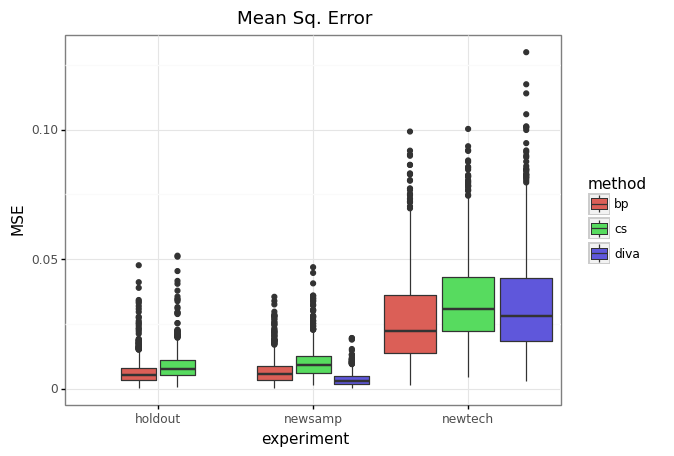

<ggplot: (8726810035836)>

In [43]:
plot_df = pd.concat([diva_newsamp_err, diva_newtech_err, 
                     cs_unseen_err, cs_newsamp_err, cs_newtech_err,
                     bp_unseen_err, bp_newsamp_err, bp_newtech_err,])
print(plot_df)
(
    gg.ggplot(plot_df[plot_df["error_type"] == "MSQ"]) + 
    gg.aes(fill = "method", y = "error", x = "experiment") +
    gg.geom_boxplot() +
    gg.labs(title="Mean Sq. Error", y="MSE") +
    gg.theme_bw()

)



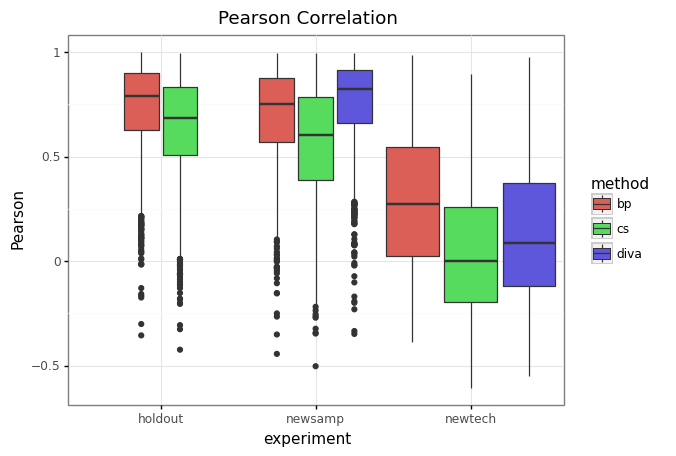

<ggplot: (8726820347694)>

In [44]:
(
    gg.ggplot(plot_df[plot_df["error_type"] == "PEAR"]) + 
    gg.aes(fill = "method", y = "error", x = "experiment") +
    gg.geom_boxplot() +
    gg.labs(title="Pearson Correlation", y="Pearson") +
    gg.theme_bw()

)

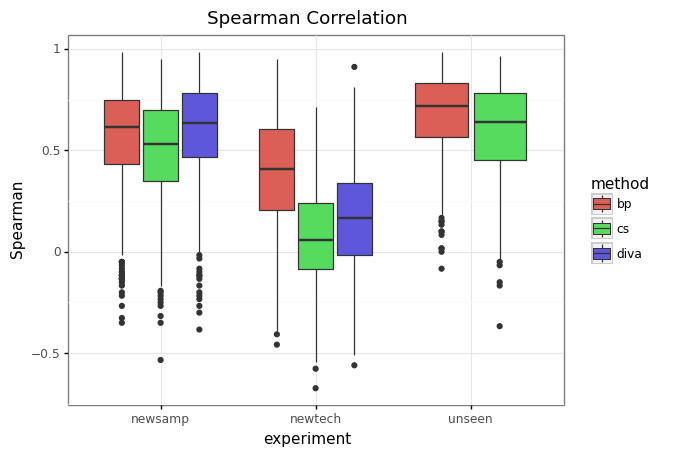

<ggplot: (8726820347685)>

In [ ]:
(
    gg.ggplot(plot_df[plot_df["error_type"] == "SPR"]) + 
    gg.aes(fill = "method", y = "error", x = "experiment") +
    gg.geom_boxplot() +
    gg.labs(title="Spearman Correlation", y="Spearman") +
    gg.theme_bw()
)